In [170]:
# LOAD PACKAGES
from scipy.spatial.transform import Rotation as R
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings; warnings.simplefilter('ignore')
from matplotlib.lines import Line2D

## STEP 0: DATA PREP

In [171]:
# LOAD THE DATA
df_raw = pd.read_table('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1_continuous_export_split#3.txt.txt')
gps = pd.read_csv('/Users/rhemitoth/Documents/PhD/Cembra/Dead_Reckoning/Data/Gundog_Tutorial/L1.GPS.UTM.csv')

In [172]:
# Convert timestamp from string to datetime
df_raw['datetime_txt'] = df_raw['Date'] + " " + df_raw['Time hh:mm:ss.ddd']
df_raw['datetime'] = pd.to_datetime(df_raw['datetime_txt'], format = '%d/%m/%Y %H:%M:%S.%f')

gps['datetime_txt'] = gps['Date'] + " " + gps['Time']
gps['datetime'] = pd.to_datetime(gps['datetime_txt'], format = '%d/%m/%Y %H:%M:%S')

In [173]:
# Select Columns
df_raw = df_raw[['Acc_x',
        'Acc_y',
        'Acc_z',
        'Mag_x',
        'Mag_y',
        'Mag_z',
        'datetime']]

In [174]:
# Compute 1 second averages
df_raw.set_index('datetime', inplace=True, drop = False)
df_raw = df_raw.resample('1s').mean()
df_raw = df_raw.reset_index(drop=True)
df_raw['datetime'] = df_raw['datetime'].dt.floor('s')

In [175]:
# Calculate elapsed time
df_raw['elapsed_time'] = df_raw['datetime'].diff().apply(lambda x: x.total_seconds())

In [176]:
# Merge GPS and activity data
df_raw = pd.merge(df_raw, gps, on='datetime', how='left')

In [177]:
# Apply a flag for 1st GPS fix of every hour
def mark_ground_truth(row):
    seconds = row['datetime'].second
    minute = row['datetime'].minute
    if seconds == 0  and minute == 0:
        return 1
    else:
        return 0
        
df_raw['ground_truth'] = df_raw.apply(mark_ground_truth,axis=1)

In [178]:
df_raw.head(31)

,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,Time,location.lat,location.long,Height.above.msl,UTM_E,UTM_N,datetime_txt,ground_truth
0,-0.086304,-0.208716,-0.997119,-0.037402,0.071558,-0.270996,2019-02-25 22:24:00,NaN,25/02/2019,22:24:00,-26.167846,20.798018,914.0,479814.898495,7.105712e+06,25/02/2019 22:24:00,0
1,-0.038428,-0.173926,-1.043873,-0.006323,0.064746,-0.272217,2019-02-25 22:24:01,1.0,25/02/2019,22:24:01,-26.167847,20.798009,914.0,479813.999248,7.105712e+06,25/02/2019 22:24:01,0
2,0.041919,-0.208667,-1.012673,0.033252,0.066309,-0.263891,2019-02-25 22:24:02,1.0,25/02/2019,22:24:02,-26.167849,20.798000,914.0,479813.100174,7.105712e+06,25/02/2019 22:24:02,0
3,0.148633,-0.193091,-1.013867,0.047485,0.065674,-0.259741,2019-02-25 22:24:03,1.0,25/02/2019,22:24:03,-26.167850,20.797992,914.0,479812.300863,7.105712e+06,25/02/2019 22:24:03,0
4,0.161817,-0.191895,-1.016260,0.047217,0.066699,-0.260522,2019-02-25 22:24:04,1.0,25/02/2019,22:24:04,-26.167851,20.797985,914.0,479811.601487,7.105712e+06,25/02/2019 22:24:04,0
5,0.178711,-0.188306,-1.021023,0.049585,0.067017,-0.260059,2019-02-25 22:24:05,1.0,25/02/2019,22:24:05,-26.167852,20.797981,914.0,479811.201918,7.105712e+06,25/02/2019 22:24:05,0
6,0.165503,-0.190699,-1.021094,0.049951,0.068335,-0.259229,2019-02-25 22:24:06,1.0,25/02/2019,22:24:06,-26.167852,20.797981,914.0,479811.201918,7.105712e+06,25/02/2019 22:24:06,0
7,0.176319,-0.189502,-1.017479,0.050806,0.068579,-0.257300,2019-02-25 22:24:07,1.0,25/02/2019,22:24:07,-26.167851,20.797981,914.0,479811.201746,7.105712e+06,25/02/2019 22:24:07,0
8,0.188306,-0.185913,-1.022243,0.052832,0.068994,-0.258911,2019-02-25 22:24:08,1.0,25/02/2019,22:24:08,-26.167851,20.797981,914.0,479811.201746,7.105712e+06,25/02/2019 22:24:08,0
9,0.178736,-0.191895,-1.023440,0.055469,0.067676,-0.259644,2019-02-25 22:24:09,1.0,25/02/2019,22:24:09,-26.167851,20.797981,914.0,479811.201746,7.105712e+06,25/02/2019 22:24:09,0


In [179]:
# Make a copy of the data
df = df_raw.copy()

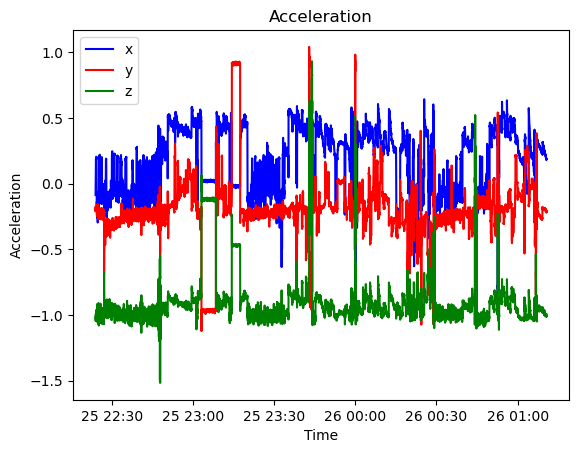

In [180]:
start = 0 
end = 10000
#PLOT ACCELERATION OVER TIME
Acc_x = df['Acc_x'].iloc[start:end]
Acc_y = df['Acc_y'].iloc[start:end]
Acc_z = df['Acc_z'].iloc[start:end]
dt = df['datetime'].iloc[start:end]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_x,  linestyle='-', color='b', label='x')
ax.plot(dt, Acc_y,  linestyle='-', color='r', label='y')
ax.plot(dt, Acc_z,  linestyle='-', color='g', label='z')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Acceleration')
ax.legend()

# Show plot
plt.show()

In [181]:
dt

0      2019-02-25 22:24:00
1      2019-02-25 22:24:01
2      2019-02-25 22:24:02
3      2019-02-25 22:24:03
4      2019-02-25 22:24:04
               ...        
9995   2019-02-26 01:10:35
9996   2019-02-26 01:10:36
9997   2019-02-26 01:10:37
9998   2019-02-26 01:10:38
9999   2019-02-26 01:10:39
Name: datetime, Length: 10000, dtype: datetime64[ns]

## STEP M1: COMPUTE ACCELERATION COMPONENTS
Static acceleration is the acceleration component due to the pull of gravity. Following Shepard et al. 2008, static acceleration can be approximated using a moving average. According to Shepard et al. 2008, the length of the running mean should correspond to the point (or follow the point) where calculated overall dynamic body acceleration (ODBA) stabizes.


In [182]:
# # WINDOW LENGTH SELECTION

# # Possible window lengths
# windows = [20,30,40,60,80,100]

# # Set up dataframe to store results
# acc_data = df[['Acc_x','Acc_y','Acc_z']]
# window_results = pd.DataFrame(columns = ['Acc_x','Acc_y','Acc_z','Gx','Gy','Gz','DAx','DAy','DAz','ODBA','WindowLength'])

# # Compute static acceleration using possible window lengths
# for win in windows:
#     # Get raw acceleration and set up results table
#     res = acc_data
#     # Compute static acceleration using rolling mean
#     res['Gx'] = res['Acc_x'].rolling(window=win).mean()
#     res['Gy'] = res['Acc_y'].rolling(window=win).mean()
#     res['Gz'] = res['Acc_z'].rolling(window=win).mean()
#     # Compute dynamic acceleration
#     res['DAx'] = res['Acc_x'] - res['Gx']
#     res['DAy'] = res['Acc_y'] - res['Gy']
#     res['DAz'] = res['Acc_z'] - res['Gz']
#     # Compute ODBA
#     res['ODBA'] = res['DAx'] ** 2 + res['DAy'] ** 2 + res['DAz'] ** 2
#     # Store Results
#     res['WindowLength'] = [win]*len(res)
#     res.head(10)
#     window_results = pd.concat([window_results, res], ignore_index=True)

# # Plot results
# grouped = window_results.groupby('WindowLength')['ODBA']
# means = grouped.mean()
# std_errors = grouped.sem()
# plt.errorbar(means.index, means, yerr=std_errors, fmt='o', color='blue', ecolor='lightblue', capsize=5)
# plt.xlabel('Running mean (s)')
# plt.ylabel('ODBA')
# plt.grid(True)
# plt.show()


In [183]:
# CALCULATE STATIC ACCELERATION
w = 10
df['Gx'] = df['Acc_x'].rolling(window=w).mean()
df['Gy'] = df['Acc_y'].rolling(window=w).mean()
df['Gz'] = df['Acc_z'].rolling(window=w).mean()

# Remove rows with NaN static accleration
df = df.iloc[w-1:].reset_index(drop=True)

In [184]:
# CALCULATE DYNAMIC ACCELERATION
df['DAx'] = df['Acc_x']-df['Gx']
df['DAy'] = df['Acc_y']-df['Gy']
df['DAz'] = df['Acc_z']-df['Gz']

In [185]:
# CALCULATE VeDBA
df['VeDBA']= (df['DAx']**2 + df['DAy']**2 + df['DAz']**2)**0.5

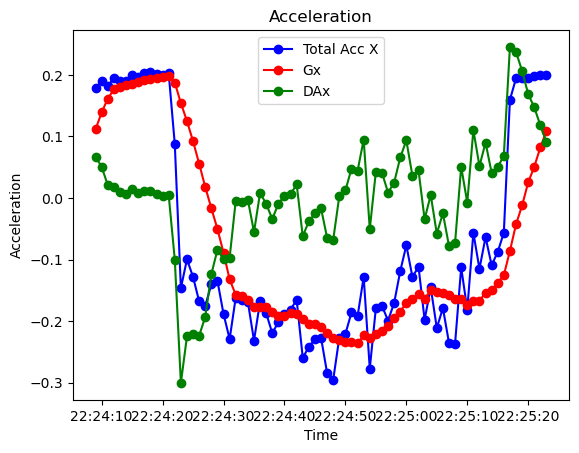

In [186]:
# PLOT ACCELERATION OVER TIME
Acc_x = df['Acc_x'].iloc[0:75]
Gx = df['Gx'].iloc[0:75]
DAx= df['DAx'].iloc[0:75]
dt = df['datetime'].iloc[0:75]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dt, Acc_x, marker='o', linestyle='-', color='b', label='Total Acc X')
ax.plot(dt, Gx, marker='o', linestyle='-', color='r', label='Gx')
ax.plot(dt, DAx, marker='o', linestyle='-', color='g', label='DAx')

# Setting labels
ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')

# Adding a title and legend
ax.set_title('Acceleration')
ax.legend()

# Show plot
plt.show()

## STEP M2: COMPUTE PITCH AND ROLL
- Pitch = rotation about the lateral axis
- Roll = rotation about the anterior-posterior axis
- Yaw (heading) = rotation about the dorso-ventral axis.

In [187]:
# COMPUTE PITCH

# Function to compute roll
def calculate_pitch(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    pitch = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(pitch)

# Compute roll
df['pitch']=df.apply(calculate_pitch,axis=1)


In [188]:
# COMPUTE ROLL

# Function to compute roll
def calculate_roll(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    roll = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(roll)

# Compute roll
df['roll']=df.apply(calculate_roll,axis=1)

## STEP M3: NORMALIZE COMPASS DATA

In [189]:
# Function to compute normalization factor
def calc_normalization_factor(row):
    Mx = row['Mag_x']
    My = row['Mag_y']
    Mz = row['Mag_z']
    fm = math.sqrt(Mx**2 + My**2 + Mz**2)
    return fm

# Compute normalization factor
df['fm'] = df.apply(calc_normalization_factor,axis=1)

# Normalize compass data
df['NMx'] = df['Mag_x']/df['fm']
df['NMy'] = df['Mag_y']/df['fm']
df['NMz'] = df['Mag_z']/df['fm']

## STEP M4: ROTATE AXES ACCORDING TO PITCH AND ROLL 

In [190]:
# Function to generate pitch rotation matrix

def get_rx(pitch):
    Rx = np.array([[1,0,0],
          [0,math.cos(pitch),math.sin(pitch)],
          [0,-math.sin(pitch),math.cos(pitch)]])
    return Rx

# Function to generate roll rotation matrix
def get_ry(roll):
    Ry = np.array([[math.cos(roll),0,-math.sin(roll)],
         [0,1,0],
         [math.sin(roll),0,math.cos(roll)]])
    return Ry

# Function to generate yaw rotation matrix
def get_rz(yaw):
    Rz = np.array([[math.cos(yaw), math.sin(yaw),0],
                 [-math.sin(yaw), math.cos(yaw), 0],
                 [0,0,1]])
    return Rz

## STEP M5: DERIVE HEADING

In [191]:
# Function to derive heading
def get_yaw(row):
    NMx = row['NMx']
    NMy = row['NMy']
    NMz = row['NMz']
    pitch = row['pitch']
    roll = row['roll']
    yaw = np.arctan2(
    NMx * np.cos(roll) - NMz * np.sin(roll),
    NMx * np.cos(pitch) + NMy * np.sin(pitch) * np.sin(roll) + NMz * np.sin(pitch) * np.cos(roll)
    )
    return yaw

# Calculate heading
df['yaw'] = df.apply(get_yaw,axis = 1)

## STEP M6: CALCULATE SPEED FROM VEDBA

In [192]:
# Initialize constants with nominal values
# These will be changed later on when aligning dead-reckoned trajectories with GPS

m = 1
c = 0.1
df['m'] = m # constant of proportionality
df['c'] = c # constant

# Calculate speed (speed = (m*VeDBA)+c
df['s'] = m*df['VeDBA'] + c

# Calculate distance (distance = speed * time)
df['d'] = df['s'] * df['elapsed_time']
df.head(10)


,Acc_x,Acc_y,Acc_z,Mag_x,Mag_y,Mag_z,datetime,elapsed_time,Date,Time,...,roll,fm,NMx,NMy,NMz,yaw,m,c,s,d
0,0.178736,-0.191895,-1.023440,0.055469,0.067676,-0.259644,2019-02-25 22:24:09,1.0,25/02/2019,22:24:09,...,0.107142,0.273992,0.202447,0.246999,-0.947632,1.241688,1,0.1,0.167368,0.167368
1,0.189478,-0.189502,-1.023487,0.057129,0.067090,-0.258252,2019-02-25 22:24:10,1.0,25/02/2019,22:24:10,...,0.133071,0.272872,0.209362,0.245866,-0.946424,1.314241,1,0.1,0.150423,0.150423
2,0.182300,-0.188306,-1.010278,0.062183,0.065405,-0.257812,2019-02-25 22:24:11,1.0,25/02/2019,22:24:11,...,0.154322,0.273152,0.227649,0.239447,-0.943844,1.339237,1,0.1,0.122824,0.122824
3,0.194287,-0.184717,-1.015016,0.077222,0.057056,-0.253369,2019-02-25 22:24:12,1.0,25/02/2019,22:24:12,...,0.168681,0.270951,0.285002,0.210575,-0.935111,1.277772,1,0.1,0.118788,0.118788
4,0.189502,-0.195484,-1.001856,0.079932,0.054590,-0.251123,2019-02-25 22:24:13,1.0,25/02/2019,22:24:13,...,0.172698,0.269132,0.296998,0.202837,-0.933086,1.269775,1,0.1,0.118747,0.118747
5,0.190699,-0.196680,-1.006617,0.081909,0.053735,-0.250024,2019-02-25 22:24:14,1.0,25/02/2019,22:24:14,...,0.175549,0.268531,0.305027,0.200109,-0.931083,1.264653,1,0.1,0.113771,0.113771
6,0.200269,-0.199072,-1.016284,0.084253,0.052563,-0.249024,2019-02-25 22:24:15,1.0,25/02/2019,22:24:15,...,0.177614,0.268094,0.314267,0.196064,-0.928868,1.256481,1,0.1,0.116719,0.116719
7,0.196680,-0.201489,-1.009032,0.085132,0.052539,-0.249072,2019-02-25 22:24:16,1.0,25/02/2019,22:24:16,...,0.180703,0.268412,0.317169,0.195741,-0.927949,1.259084,1,0.1,0.113428,0.113428
8,0.202661,-0.199072,-1.006665,0.083789,0.052344,-0.248804,2019-02-25 22:24:17,1.0,25/02/2019,22:24:17,...,0.183324,0.267701,0.312995,0.195531,-0.929409,1.270705,1,0.1,0.114498,0.114498
9,0.205053,-0.196680,-1.012647,0.082886,0.054736,-0.251929,2019-02-25 22:24:18,1.0,25/02/2019,22:24:18,...,0.185023,0.270803,0.306074,0.202126,-0.930303,1.283493,1,0.1,0.112322,0.112322


## STEP M7: PERFORM DEAD RECKONING CALCULATION

In [193]:
def dead_reckoning_magnetometer(acc_data, ground_truth_points):

    """
    This function calculates dead reckoning trajectories from accelerometer and magnetometer data and aligns the calculated trajectory with
    ground truth points.

    Args:
    acc_data (pandas df): accelerometery data 
    ground_truth_points (pandas df): ground truth points

    Returns:
    trajectory (pandas df): dead reckoned trajectory
    """

    # Initialize empty dataframe to store results
    results = pd.DataFrame(columns = acc_data.columns)

    # Calculate dead-reckoned trajectories in segments starting at each ground truth point
    num_gtps = len(ground_truth_points)
    for i in range(0,num_gtps-1):
        print(i)

        # Get GTPs at start and end of first segment
        gtp_start = ground_truth_points.iloc[i]
        gtp_end = ground_truth_points.iloc[i+1]

        # Get the timestamps of first and last GTPs
        gtp_start_ts = gtp_start['datetime']
        gtp_end_ts = gtp_end['datetime']

        # Filter for acc + mag data that falls between first and last GTP
        acc_data_copy = acc_data.copy()
        acc_filt = acc_data_copy[(acc_data_copy['datetime'] >= gtp_start_ts) & (acc_data_copy['datetime'] <= gtp_end_ts)]
        acc_filt = acc_filt.reset_index()

        # Initialize the transformation matrix
        transformation_matrix = np.eye(4)
        transformation_matrix

        # Initialize position
        utm_x0 = gtps.loc[0,'UTM_E']
        utm_y0 = gtps.loc[0,'UTM_N']
        x0 = gtp_start['UTM_E'] - utm_x0
        y0 = gtp_start['UTM_N'] - utm_y0
        position = np.array([[x0],[y0],[0]])
    
        # Initialize columns for dead-reckoned coordinates
        acc_filt['DR_x'] = -999.0
        acc_filt.loc[0,'DR_x'] = gtp_start['UTM_E'] - utm_x0
        acc_filt['DR_y'] = -999.0
        acc_filt.loc[0,'DR_y'] = gtp_start['UTM_N'] - utm_y0
        acc_filt['DR_utm_x'] = -999.0
        acc_filt.loc[0,'DR_utm_x'] = gtp_start['UTM_E']
        acc_filt['DR_utm_y'] = -999.0
        acc_filt['DR_utm_y'] = gtp_start['UTM_N']
    
        # Initialize direciton
        initial_direction = np.array([[0],[1],[0]])

        # Perform dead reckoning
        for j in range(len(acc_filt)-1 ):
                
            # Construct the rotation matrix
            pitch = acc_filt.loc[j,'pitch']
            roll = acc_filt.loc[j,'roll']
            yaw = acc_filt.loc[j,'yaw']
            Rx = get_rx(pitch)
            Ry = get_ry(roll)
            Rz = get_rz(yaw)
            rotation_matrix = Rz @ Ry @ Rx
        
            # Compute the displacement vector
            direction_vector = rotation_matrix @ initial_direction
            distance = acc_filt.loc[j,'d']
            displacement_vector = direction_vector * distance
                
            #update homo_trans_step
            transformation_step = np.append(np.append(rotation_matrix, np.zeros([3,1]), axis = 1), np.array([[0,0,0,1]]), axis = 0)
            transformation_step[:3,-1] = displacement_vector.flatten()
        
            # Perform initial calculation of coordinates
            next_position = position + displacement_vector
            acc_filt.loc[j+1,'DR_x'] = next_position[0]
            acc_filt.loc[j+1,'DR_utm_x'] = displacement_vector[0] + acc_filt.loc[j,'DR_utm_x']
            acc_filt.loc[j+1,'DR_y'] = next_position[1]
            acc_filt.loc[j+1,'DR_utm_y'] = displacement_vector[1] + acc_filt.loc[j,'DR_utm_y']
            acc_filt.loc[j+1,'DR_z'] = next_position[2]
        
            # Update position
            position = next_position

        # Perform heading and distance corrections

        # Get first and last GTP
        gps_x0 = gtp_start['UTM_E'] - utm_x0
        gps_y0 = gtp_start['UTM_N'] - utm_y0
        gps_x1 = gtp_end['UTM_E'] - utm_x0
        gps_y1 = gtp_end['UTM_N'] - utm_y0

        
        # Get get first and last dead-reckoned point
        dr_x0 = acc_filt['DR_x'].iloc[0]
        dr_y0 = acc_filt['DR_y'].iloc[0]
        dr_x1 = acc_filt['DR_x'].iloc[-1]
        dr_y1 = acc_filt['DR_y'].iloc[-1]
        
        # Define center of rotation
        x_center = dr_x0
        y_center = dr_y0
        center_of_rotation = np.array([[x_center],[y_center],[0]])

        # Subtract the center of rotation from pts
        gps_x0 = gps_x0 - x_center
        gps_y0 = gps_y0 - y_center
        gps_x1 = gps_x1 - x_center
        gps_y1 = gps_y1 - y_center
        dr_x0  = dr_x0 - x_center
        dr_y0 = dr_y0 - y_center
        dr_x1 = dr_x1 - x_center
        dr_y1 = dr_y1 - y_center
            
        # Calculate the distance correction factor
        dist_GPS = math.sqrt((gps_x1-gps_x0)**2 + (gps_y1 - gps_y0)**2)
        dist_dr = math.sqrt((dr_x1-dr_x0)**2 + (dr_y1 - dr_y0)**2)
        dist_corr_fact = (dist_GPS/dist_dr)
        
        # Calculate heading correction factor
        bearing_GPS = math.atan2(gps_y1-gps_y0,gps_x1-gps_x0) 
        bearing_dr = math.atan2(dr_y1-dr_y0,dr_x1-dr_x0) 
        heading_corr_fact = (bearing_GPS-bearing_dr)
        # if heading_corr_fact < -math.pi:
        #     heading_corr_fact += (360 * 0.0174533)
        # elif heading_corr_fact > math.pi:
        #     heading_corr_fact -= (360 * 0.0174533)
        heading_correction = R.from_euler('xyz', [0,0,heading_corr_fact]).as_matrix()
    
        # Get points that will be corrected
        Xs = acc_filt['DR_x'].to_numpy()
        Ys = acc_filt['DR_y'].to_numpy()
        Zs = np.zeros(len(acc_filt))
        initial_coords = np.array([Xs,Ys,Zs]) - center_of_rotation
        
        # Perform Correction
        new_coords = ((heading_correction @ initial_coords)*np.array([[dist_corr_fact],[dist_corr_fact],[dist_corr_fact]]) ) + center_of_rotation
        acc_filt['DR_x'] = new_coords[0]
        acc_filt['DR_y'] = new_coords[1]
        acc_filt['DR_utm_x'] = acc_filt['DR_x'] + utm_x0
        acc_filt['DR_utm_y'] = acc_filt['DR_y'] + utm_y0
        
        # Filter for rows between GTPs and append to df_corrected
        results = pd.concat([results, acc_filt], ignore_index=True)

    return results
    
    
    
            

In [236]:
# Set start and end for calculation
T = 8 # total time in hrs
start = 0 * 60 * 60 
end = (T * 60 * 60) + start
df = df.iloc[start:end]

In [237]:
# Extract ground truth points
gtps = df[df['ground_truth'] == 1].reset_index()

In [238]:
# Perform dead reckoning
dr_acc_mag = dead_reckoning_magnetometer(acc_data = df, ground_truth_points = gtps) 

0
1
2
3
4
5


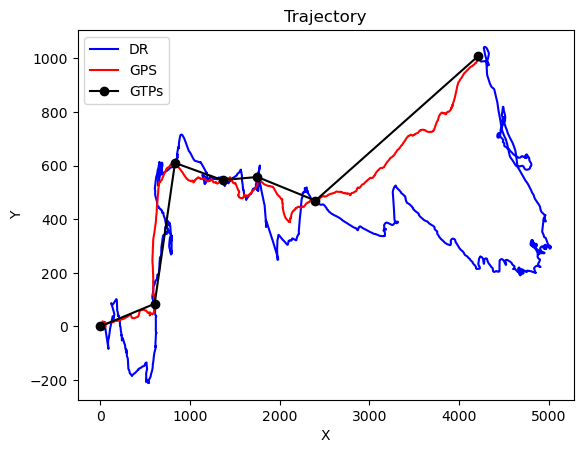

In [239]:
# Get data for plotting
dr_x = dr_acc_mag['DR_x']
dr_y = dr_acc_mag['DR_y']
utm_x = dr_acc_mag['UTM_E'] - dr_acc_mag.loc[0,'UTM_E']
utm_y = dr_acc_mag['UTM_N'] - dr_acc_mag.loc[0,'UTM_N']
gtps_x = gtps['UTM_E'] - dr_acc_mag.loc[0,'UTM_E']
gtps_y = gtps['UTM_N'] - dr_acc_mag.loc[0,'UTM_N']

# Initialize plot 
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dr_x,dr_y,  linestyle='-', color='b', label='DR')
ax.plot(utm_x,utm_y,  linestyle='-', color='r', label='GPS')
ax.plot(gtps_x,gtps_y, marker='o',  color='black', label='GTPs')

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Adding a title and legend
ax.set_title('Trajectory')
ax.legend()

# Show plot
plt.show()

# Accelerometer Only Dead Reckoning

## Step A1: Calculate acceleration components

In [250]:
# Make a copy of the raw data
df_acc = df_raw.copy()

In [251]:
# CALCULATE STATIC ACCELERATION
w = 10
df_acc['Gx'] = df_acc['Acc_x'].rolling(window=w).mean()
df_acc['Gy'] = df_acc['Acc_y'].rolling(window=w).mean()
df_acc['Gz'] = df_acc['Acc_z'].rolling(window=w).mean()

# Remove rows with NaN static accleration
df_acc = df_acc.iloc[w-1:].reset_index(drop=True)

In [252]:
# Calculate Dynamic Acceleration
df_acc['DAx'] = df_acc['Acc_x'] - df_acc['Gx']
df_acc['DAy'] = df_acc['Acc_y'] - df_acc['Gy']
df_acc['DAz'] = df_acc['Acc_z'] - df_acc['Gz']

## Step A4: Compute pitch and roll

In [253]:
# COMPUTE Pitch
# Function to compute pitch
def calculate_pitch(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    pitch = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(pitch)

# Compute pitch
df_acc['pitch']=df_acc.apply(calculate_pitch,axis=1)

In [254]:
# COMPUTE ROLL

# Function to compute roll
def calculate_roll(row):
    gx = row['Gx']
    gy = row['Gy']
    gz = row['Gz']
    roll = math.atan2(gx,math.sqrt(gy**2 + gz**2))
    return(roll)

# Compute roll
df_acc['roll']=df_acc.apply(calculate_roll,axis=1)

In [255]:
df_acc[['Acc_x','DAx','Gx']].head()

,Acc_x,DAx,Gx
0,0.178736,0.067214,0.111521
1,0.189478,0.050378,0.139099
2,0.182300,0.021128,0.161172
3,0.194287,0.017878,0.176409
4,0.189502,0.009006,0.180496


## Step A5: Perform initial dead-reckoning

In [256]:
def dead_reckoning_acc(acc_data, ground_truth_points):

    """
    This function calculates dead reckoning trajectories from accelerometer data and aligns the calculated trajectory with
    ground truth points.

    Args:
    acc_data (pandas df): accelerometery data 
    ground_truth_points (pandas df): ground truth points

    Returns:
    trajectory (pandas df): dead reckoned trajectory
    """

    # Initialize empty dataframe to store results
    results = pd.DataFrame(columns = acc_data.columns)

    # Calculate dead-reckoned trajectories in segments starting at each ground truth point
    num_gtps = len(ground_truth_points)
    for i in range(0,num_gtps-1):
        print(i)

        # Get GTPs at start and end of first segment
        gtp_start = ground_truth_points.iloc[i]
        gtp_end = ground_truth_points.iloc[i+1]

        # Get the timestamps of first and last GTPs
        gtp_start_ts = gtp_start['datetime']
        gtp_end_ts = gtp_end['datetime']

        # Filter for acc + mag data that falls between first and last GTP
        acc_data_copy = acc_data.copy()
        acc_filt = acc_data_copy[(acc_data_copy['datetime'] >= gtp_start_ts) & (acc_data_copy['datetime'] <= gtp_end_ts)]
        acc_filt = acc_filt.reset_index()

        # Initialize the transformation matrix
        transformation_matrix = np.eye(4)
        transformation_matrix

        # Initialize position
        utm_x0 = gtps.loc[0,'UTM_E']
        utm_y0 = gtps.loc[0,'UTM_N']
        x0 = gtp_start['UTM_E'] - utm_x0
        y0 = gtp_start['UTM_N'] - utm_y0
        position = np.array([[x0],[y0],[0]])
    
        # Initialize columns for dead-reckoned coordinates
        acc_filt['DR_x'] = -999.0
        acc_filt.loc[0,'DR_x'] = gtp_start['UTM_E'] - utm_x0
        acc_filt['DR_y'] = -999.0
        acc_filt.loc[0,'DR_y'] = gtp_start['UTM_N'] - utm_y0
        acc_filt['DR_utm_x'] = -999.0
        acc_filt.loc[0,'DR_utm_x'] = gtp_start['UTM_E']
        acc_filt['DR_utm_y'] = -999.0
        acc_filt['DR_utm_y'] = gtp_start['UTM_N']

        # Set initial velocity = avg
        x0 = gtp_start['UTM_E']
        x1 = gtp_end['UTM_E']
        y0 = gtp_start['UTM_N']
        y1 = gtp_end['UTM_N']
        dist_x = x1 - x0
        vx_init = dist_x/60/60
        dist_y = y1 - y0
        vy_init = dist_y/60/60
        acc_filt['vx'] = vx_init
        acc_filt['vy'] = vy_init
        
        # Perform dead reckoning
        for j in range(len(acc_filt)-1 ):
                
            # Construct the rotation matrix
            pitch = acc_filt.loc[j,'pitch']
            roll = acc_filt.loc[j,'roll']
            Rx = get_rx(pitch)
            Ry = get_ry(roll)
            rotation_matrix = Ry @ Rx

            # Compute displacement in x
            acc_x = (acc_filt.loc[j,'DAx']) # acceleration [a(t)]
            vx0 = acc_filt.loc[j,'vx']
            c = vx0 
            dx = acc_x/2 + c

            # Update velocity
            vx_new = acc_x + c
            acc_filt.loc[j+1,'vx'] = acc_x + c

            # Calculate displacement in y
            acc_y = (acc_filt.loc[j,'DAy']) # acceleration [a(t)]
            vy0 = acc_filt.loc[j,'vy']
            c = vy0
            dy = acc_y/2 + c

            # Update velocity
            vy_new = acc_y + c
            acc_filt.loc[j+1,'vy'] = acc_y + c

            # Apply displacement vector
            displacement_vector = rotation_matrix @ np.array([[dx],[dy],[0]])
            
            # Perform initial calculation of coordinates
            current_position = position
            next_position = current_position + displacement_vector
            acc_filt.loc[j+1,'DR_x'] = next_position[0]
            acc_filt.loc[j+1,'DR_utm_x'] = displacement_vector[0] + acc_filt.loc[j,'DR_utm_x']
            acc_filt.loc[j+1,'DR_y'] = next_position[1]
            acc_filt.loc[j+1,'DR_utm_y'] = displacement_vector[1] + acc_filt.loc[j,'DR_utm_y']
            acc_filt.loc[j+1,'DR_z'] = next_position[2]
        
            # Update position
            position = next_position

        # Perform heading and distance corrections

        # Get first and last GTP
        gps_x0 = gtp_start['UTM_E'] - utm_x0
        gps_y0 = gtp_start['UTM_N'] - utm_y0
        gps_x1 = gtp_end['UTM_E'] - utm_x0
        gps_y1 = gtp_end['UTM_N'] - utm_y0

        
        # Get get first and last dead-reckoned point
        dr_x0 = acc_filt['DR_x'].iloc[0]
        dr_y0 = acc_filt['DR_y'].iloc[0]
        dr_x1 = acc_filt['DR_x'].iloc[-1]
        dr_y1 = acc_filt['DR_y'].iloc[-1]
        
        # Define center of rotation
        x_center = dr_x0
        y_center = dr_y0
        center_of_rotation = np.array([[x_center],[y_center],[0]])

        # Subtract the center of rotation from pts
        gps_x0 = gps_x0 - x_center
        gps_y0 = gps_y0 - y_center
        gps_x1 = gps_x1 - x_center
        gps_y1 = gps_y1 - y_center
        dr_x0  = dr_x0 - x_center
        dr_y0 = dr_y0 - y_center
        dr_x1 = dr_x1 - x_center
        dr_y1 = dr_y1 - y_center
            
        # Calculate the distance correction factor
        dist_GPS = math.sqrt((gps_x1-gps_x0)**2 + (gps_y1 - gps_y0)**2)
        dist_dr = math.sqrt((dr_x1-dr_x0)**2 + (dr_y1 - dr_y0)**2)
        dist_corr_fact = (dist_GPS/dist_dr)
        
        # Calculate heading correction factor
        bearing_GPS = math.atan2(gps_y1-gps_y0,gps_x1-gps_x0) 
        bearing_dr = math.atan2(dr_y1-dr_y0,dr_x1-dr_x0) 
        heading_corr_fact = (bearing_GPS-bearing_dr)
        # if heading_corr_fact < -math.pi:
        #     heading_corr_fact += (360 * 0.0174533)
        # elif heading_corr_fact > math.pi:
        #     heading_corr_fact -= (360 * 0.0174533)
        heading_correction = R.from_euler('xyz', [0,0,heading_corr_fact]).as_matrix()
    
        # Get points that will be corrected
        Xs = acc_filt['DR_x'].to_numpy()
        Ys = acc_filt['DR_y'].to_numpy()
        Zs = np.zeros(len(acc_filt))
        initial_coords = np.array([Xs,Ys,Zs]) - center_of_rotation
        
        # Perform Correction
        new_coords = ((heading_correction @ initial_coords)*np.array([[dist_corr_fact],[dist_corr_fact],[dist_corr_fact]]) ) + center_of_rotation
        acc_filt['DR_x'] = new_coords[0]
        acc_filt['DR_y'] = new_coords[1]
        acc_filt['DR_utm_x'] = acc_filt['DR_x'] + utm_x0
        acc_filt['DR_utm_y'] = acc_filt['DR_y'] + utm_y0
        
        # Filter for rows between GTPs and append to df_corrected
        results = pd.concat([results, acc_filt], ignore_index=True)

    return results     

In [257]:
# Set start and end for calculation
T = 8 # total time in hrs
start = 0 * 60 * 60
end = (T * 60 * 60) + start
df_acc = df_acc.iloc[start:end]

# Extract ground truth points
gtps = df_acc[df_acc['ground_truth'] == 1].reset_index()

In [258]:
dr_acc_only = dead_reckoning_acc(acc_data = df_acc, ground_truth_points = gtps)

0
1
2
3
4
5
6


## RESULTS

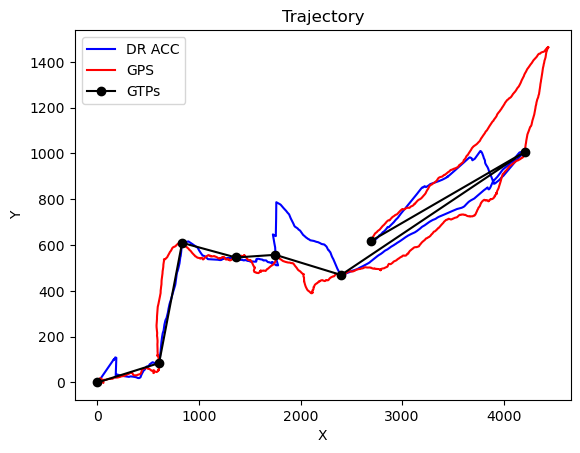

In [261]:
# Get data for plotting
x0 = gtps.loc[0,'UTM_E']
y0 = gtps.loc[0,'UTM_N']
dr_x_acc = dr_acc_only['DR_x']
dr_y_acc = dr_acc_only['DR_y']
dr_x_mag = dr_acc_mag['DR_x']
dr_y_mag = dr_acc_mag['DR_y']
utm_x = dr_acc_only['UTM_E'] - x0
utm_y = dr_acc_only['UTM_N'] - y0
gtps_x = gtps['UTM_E'] - x0
gtps_y = gtps['UTM_N'] - y0

# Initialize plot 
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the trajectory
ax.plot(dr_x_acc,dr_y_acc,  linestyle='-', color='b', label='DR ACC')
#ax.plot(dr_x_mag,dr_y_mag,  linestyle='-', color='g', label='DR ACC+MAG')
ax.plot(utm_x,utm_y,  linestyle='-', color='r', label='GPS')
ax.plot(gtps_x,gtps_y, marker='o',  color='black', label='GTPs')

# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Adding a title and legend
ax.set_title('Trajectory')
ax.legend()

# Show plot
plt.show()